## ToDos

* Review term frequency in major and minor classes
* Pre-compute DTM and sampling for training data sets
* LDA will take a long time...can I fit on something smaller and then partial fit
* Figure out AWS
* Use spaCy to transform documents into vectorized form. This will bypass count/tf-idf -> PCA/LDA pipeline


## Fixed Data
1. CountVectorizer
2. tf-idf
3. spaCy word embeddings
4. Sampling

Build out all of the above data structures, and then pickle the class. I can then reload the class to run the model pipelines with right training data sets. 

How do I maintain the test data?
* Create models to transform the text later.
* Transform and save the data


### Pipelines
1. Count/tf-idf -> PCA / LDA -> Supervised Learning
  * stemming applied
  * english words
2. Word Embeddings -> Supervised Learning

In [1]:
import AmazonReviews

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ar = AmazonReviews.AmazonReviews()

PATH = '../data/amazon_reviews_us_Toys_v1_00.tsv'
ar.load_data(PATH)

ar.calc_trend_score()

ar.create_observations()

# ar.create_train_test_split(train_reduction=.1)
ar.create_train_test_split()
# ar.dump_models()

# ar = ar.load_models()

Read from pickle...


Review the distribution of the first review data. 1/1/2014 is the most popular. May need to move the cutoff date.

2014-01-01    0.030230
2014-01-02    0.029510
2014-01-03    0.026328
2014-01-04    0.016026
2014-01-07    0.014318

In [4]:
# ar.reviews_selected_df.min_review_date.value_counts(normalize=True).sort_values(ascending = False).head()

In [5]:
# ar.product_trend_df[ar.product_trend_df.trend == 1].describe()

## DTM / Sampling Creation

Create DTM and only restrict features to English words in the `nltk.corpus.words`

In [84]:
from nltk.corpus import words, stopwords
from nltk import SnowballStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score


import numpy as np
import pandas as pd

# skf = StratifiedKFold(n_splits = 3, random_state=ar.RANDOM_STATE)

stemmer = SnowballStemmer('english')

def english_corpus(doc, tkpat=re.compile('\\b[a-z][a-z]+\\b')):
    return [stemmer.stem(w) for w in tkpat.findall(doc) if w not in ['br', 've']]


In [7]:
## Create each pipe and add it to the data dictionary.
pre_process_pipe = imbPipeline([
                          ('cnt_v', CountVectorizer(
                                        stop_words='english', 
                                        tokenizer=english_corpus, 
                                        min_df=2)),
                          ('sm', SMOTE(random_state=42, n_jobs=-1))]) 

ar.pre_process_data(pre_process_pipe, 'cnt_v_1_gram_sm')

In [8]:
first_pipe = imbPipeline([
                          ('lda', LatentDirichletAllocation(         # could I fit on 1 of the 10 folds, and then partial fit
                                        n_jobs=-1, 
                                        learning_method='online',    
                                        random_state=42)),
                          ('log_transform', FunctionTransformer(np.log)),
                          ('ss', StandardScaler()),
                          ('log_reg', LogisticRegression(random_state=42))])

params = {
    'lda__n_components': Integer(5, 20),
    'lda__learning_decay': Real(0.5, 1),
    'log_reg__C': Categorical([0.001,0.01,0.1,1,10,100])
}

grid = BayesSearchCV(first_pipe, params, n_jobs=-1, n_iter=20, cv=skf, scoring='precision')

In [9]:
ar.run_model(grid, 'mvp', 'cnt_v_1_gram_sm',sample=.01)

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

In [10]:
ar.results

,mvp
Accuracy,0.229066
Precision,0.009297
Recall,0.682008
F1 Score,0.018344
AUC,0.453120


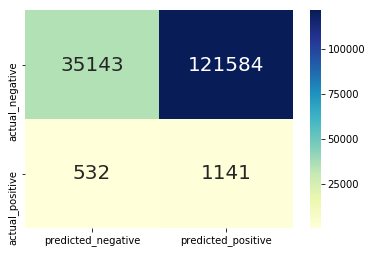

In [11]:
ar.conf_matrix('mvp')

In [12]:
ar.dump_models()

## End of MVP

In [6]:
ar = AmazonReviews.AmazonReviews()
ar = ar.load_models()

In [14]:
ar.pre_process_models.keys()

dict_keys(['cnt_v_1_gram_sm', 'cnt_v_2_gram_sm', 'tf_idf_1_gram_sm'])

In [9]:
pre_process_pipe = imbPipeline([
                          ('cnt_v', CountVectorizer(
                                        stop_words='english', 
                                        tokenizer=english_corpus, 
                                        min_df=2,
                                        ngram_range = (1,2))),
                          ('sm', SMOTE(random_state=42, n_jobs=-1))]) 

ar.pre_process_data(pre_process_pipe, 'cnt_v_2_gram_sm')

In [10]:
pre_process_pipe = imbPipeline([
                          ('cnt_v', TfidfVectorizer(
                                        stop_words='english', 
                                        tokenizer=english_corpus, 
                                        min_df=2)),
                          ('sm', SMOTE(random_state=42, n_jobs=-1))]) 

ar.pre_process_data(pre_process_pipe, 'tf_idf_1_gram_sm')

In [15]:
pre_process_pipe = imbPipeline([
                          ('cnt_v', TfidfVectorizer(
                                        stop_words='english', 
                                        tokenizer=english_corpus, 
                                        min_df=2,
                                        ngram_range = (1,2))),
                          ('sm', SMOTE(random_state=42, n_jobs=-1))]) 

ar.pre_process_data(pre_process_pipe, 'tf_idf_2_gram_sm')

In [16]:
ar.dump_models()

## Pre-processing complete

DTMs using single and bi-grams generate with `CountVectorizer` and `TfidfVectorizer` with `SMOTE` upsampling. These transformations can now be fed into a pipeline with deminesion reduction and a classification algorithm.

# CountVectorizer EDA

In [86]:
tf.shape

(158400, 3421)

In [22]:
ar.X_train.shape

(158400,)

In [85]:
cv = CountVectorizer(
                     stop_words=set(stopwords.words()), 
                        tokenizer=english_corpus, 
                        min_df=100,
                        max_df=0.2,
                        ngram_range = (1,2)) 
          

tf = cv.fit_transform(ar.X_train)

max_df = 0.5

In [27]:
vocab = np.array(cv.get_feature_names())
counts = np.array(tf.sum(0))[0,:]
vocab[np.argsort(-counts)[:100]]

array(['love', 'great', 'veri', 'like', 'good', 'just', 'look', 'littl',
       'old', 'use', 'year', 'play', 'time', 'qualiti', 'realli', 'work',
       'nice', 'perfect', 'bought', 'br', 'son', 'product', 'cute', 'fun',
       'kid', 'toy', 'year old', 'daughter', 'onli', 'price', 'make',
       'got', 'buy', 'gift', 'purchas', 'set', 'want', 'becaus',
       'recommend', 'small', 'expect', 'piec', 'size', 'color', 'come',
       'fit', 'game', 'don', 'item', 'need', 'came', 'br br', 'easi',
       'thing', 'figur', 'lot', 'order', 'thank', 'happi', 'did',
       'grandson', 'ani', 'box', 'card', 'way', 'pictur', 'togeth', 'day',
       'awesom', 'arriv', 'better', 'pretti', 'think', 'big', 'high',
       'ship', 'didn', 'collect', 'receiv', 'birthday', 'doll', 'enjoy',
       'doe', 'say', 'christma', 'bit', 'plastic', 'disappoint', 'fast',
       'worth', 'right', 'excel', 'thought', 'new', 'differ', 'hard',
       'packag', 'money', 'doesn', 'tri'], dtype='<U55')

max_df = 0.2, min_df = 100

In [90]:
vocab = np.array(cv.get_feature_names())
counts = np.array(tf.sum(0))[0,:]
vocab[np.argsort(-counts)[:100]]

array(['great', 'veri', 'one', 'like', 'good', 'look', 'use', 'would',
       'get', 'play', 'littl', 'well', 'old', 'year', 'time', 'realli',
       'toy', 'game', 'work', 'qualiti', 'nice', 'product', 'kid',
       'perfect', 'fun', 'bought', 'make', 'cute', 'set', 'onli',
       'year old', 'daughter', 'made', 'price', 'got', 'piec', 'buy',
       'much', 'figur', 'gift', 'card', 'purchas', 'becaus', 'put',
       'even', 'small', 'color', 'size', 'go', 'expect', 'recommend',
       'fit', 'item', 'doll', 'need', 'box', 'thing', 'order', 'still',
       'lot', 'easi', 'came', 'two', 'puzzl', 'togeth', 'ani', 'happi',
       'back', 'first', 'pictur', 'thank', 'could', 'way', 'grandson',
       'day', 'think', 'pretti', 'better', 'part', 'big', 'take',
       'awesom', 'collect', 'arriv', 'ship', 'receiv', 'high', 'detail',
       'car', 'plastic', 'birthday', 'doe', 'say', 'bit', 'see', 'enjoy',
       'right', 'differ', 'around', 'christma'], dtype='<U20')

In [72]:
counts

array([ 129,  299, 2461, ...,  124,  188,  151], dtype=int64)

In [61]:
cv.vocabulary_['ve']

3110

In [63]:
t_word = ar.X_train[ar.X_train.str.contains('ve ')].head(1)
print(t_word.values)
# for w in [0].split():
#     print(w)

["Not worth   bucks!!!!! This toy feels really cheap, the plastic is very light feeling (kind of like the imitation &# ;hot wheels&# ; cars you get at the dollar store). After only   day of play the figure became loose. When my son tries to transform it the pieces won't stay in place. Also the figure is very small about   or   inches. The only positive thing I can say about this is the metallic paint is really nice."]


In [87]:
n_components = 5

lda = LatentDirichletAllocation(learning_method='online',
                                learning_decay=0.6,
                                batch_size=256,
                                learning_offset=1024,
                                n_components=n_components,
                                n_jobs=-1,
                                topic_word_prior=0.005,)

lda.fit(tf)

LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.6,
             learning_method='online', learning_offset=1024,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=0.005,
             total_samples=1000000.0, verbose=0)

In [92]:
lda_tf = lda.transform(tf)

In [93]:
lda_tf.shape

(158400, 5)

In [94]:
from xgboost import XGBClassifier

In [103]:
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(lda_tf, ar.y_train)

In [104]:
X_train_smote.shape

(313454, 5)

In [105]:
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [118]:
y_pred = grid.best_estimator_.predict(lda_tf)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [101]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_score

In [124]:
y_pred = grid.best_estimator_.predict(lda_tf)
print(roc_auc_score(ar.y_train, y_pred))
print(f1_score(ar.y_train, y_pred))
print(precision_score(ar.y_train, y_pred))
print(confusion_matrix(ar.y_train, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7584120244936818
0.0821199767035527
0.04372262490794217
[[132056  24671]
 [   545   1128]]


Added a log transform to the probabilities.

In [127]:
y_pred = grid.best_estimator_.predict(lda_tf)
print(roc_auc_score(ar.y_train, y_pred))
print(f1_score(ar.y_train, y_pred))
print(precision_score(ar.y_train, y_pred))
print(confusion_matrix(ar.y_train, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8210689786971472
0.11479523254771931
0.06204892225720513
[[137363  19364]
 [   392   1281]]


This is with bi-grams and 5 topics with SMOTE. Could look at the following,

* tri-grams or single-grams or only bi-grams
* tweak max/min df
* Increasing the components for LDA.
* Build a spaCy document vector matrix (a new notebook)

In [126]:
def on_step(optim_result):
    score = grid.best_score_
    print(f'best score: {score:.3}')
#     if score >= 0.98:
#         print('Interrupting!') # could stop it early if you hit some goal
#         return True

xgb_pipeline = Pipeline([
        ('log_transform', FunctionTransformer(np.log)),
        ('xgb', XGBClassifier(n_jobs=-1))]
)

xgb_params = {
    'xgb__n_estimators': Integer(100, 500),
    'xgb__learning_rate': Real(0,1),
    'xgb__max_depth': Integer(2, 5)
}



grid = BayesSearchCV(xgb_pipeline, xgb_params, cv=3, n_jobs=-1, scoring='precision', n_iter=4)
grid.fit(X_train_smote, y_train_smote, callback=on_step) # add callback to print the score of each BayesSearch

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best score: 0.753


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best score: 0.828


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best score: 0.862


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best score: 0.862


BayesSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('log_transform', FunctionTransformer(accept_sparse=False, func=<ufunc 'log'>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, g...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_iter=4, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='precision',
       search_spaces={'xgb__n_estimators': Integer(low=100, high=500), 'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='identity'), 'xgb__max_depth': Integer(low=2, high=5)},
       verbose=0)

## Notes
* Do NOT tf-idf if using LDA
* tf-idf could be helpful for NMF

In [91]:
for topic in range(n_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
great
good
veri
qualiti
product
price
work
item
ship
thank

TOPIC 1
one
would
get
piec
like
put
use
onli
puzzl
becaus

TOPIC 2
veri
look
cute
nice
well
like
figur
doll
great
littl

TOPIC 3
old
year
play
year old
great
fun
gift
daughter
kid
bought

TOPIC 4
card
game
one
use
get
onli
make
set
like
model



In [69]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [73]:
sw = set(stopwords.words())
'just' in sw

True

In [89]:
pyLDAvis.sklearn.prepare(lda, tf, cv)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.124092 -0.117158       1        1  32.884614
4      0.119885 -0.159743       2        1  22.742888
3      0.149049  0.311623       3        1  17.018974
2     -0.025797 -0.074713       4        1  16.290978
0     -0.367229  0.039990       5        1  11.062546, topic_info=     Category          Freq             Term         Total  loglift  logprob
term                                                                        
1260  Default  36214.000000            great  36214.000000  30.0000  30.0000
3167  Default  33386.000000             veri  33386.000000  29.0000  29.0000
1191  Default  20861.000000             good  20861.000000  28.0000  28.0000
2012  Default  15170.000000              old  15170.000000  27.0000  27.0000
3396  Default  14892.000000             year  14892.000000  26.0000  26.0000
2310  Default  12224.000000          product  12224.000000  25.0000  25.0000
2366  Default  12599.000000          qualiti  12599.000000  24.0000  24.0000
605   Default  11134.000000             cute  11134.000000  23.0000  23.0000
2210  Default  16900.000000             play  16900.000000  22.0000  22.0000
3399  Default  10872.000000         year old  10872.000000  21.0000  21.0000
1670  Default  18933.000000             look  18933.000000  20.0000  20.0000
1960  Default  12437.000000             nice  12437.000000  19.0000  19.0000
1144  Default   9161.000000             gift   9161.000000  18.0000  18.0000
3328  Default  13204.000000             work  13204.000000  17.0000  17.0000
1067  Default  11858.000000              fun  11858.000000  16.0000  16.0000
2289  Default  10543.000000            price  10543.000000  15.0000  15.0000
1514  Default  11879.000000              kid  11879.000000  14.0000  14.0000
968   Default   9785.000000            figur   9785.000000  13.0000  13.0000
1481  Default   7378.000000             item   7378.000000  12.0000  12.0000
731   Default   7223.000000             doll   7223.000000  11.0000  11.0000
386   Default   8841.000000             card   8841.000000  10.0000  10.0000
635   Default  10875.000000         daughter  10875.000000   9.0000   9.0000
1090  Default  13066.000000             game  13066.000000   8.0000   8.0000
2643  Default   5157.000000             ship   5157.000000   7.0000   7.0000
2186  Default  10096.000000             piec  10096.000000   6.0000   6.0000
2948  Default   5925.000000            thank   5925.000000   5.0000   5.0000
3268  Default  16301.000000             well  16301.000000   4.0000   4.0000
1772  Default  10735.000000             made  10735.000000   3.0000   3.0000
1250  Default   5731.000000         grandson   5731.000000   2.0000   2.0000
1597  Default  23306.000000             like  23306.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
2643   Topic5   5109.392252             ship   5157.349593   2.1923  -4.0287
2604   Topic5   2139.308954           seller   2143.173627   2.1998  -4.8993
1381   Topic5   1091.824906     high qualiti   1095.532595   2.1982  -5.5719
1021   Topic5   2140.381434              fli   2210.555164   2.1693  -4.8987
671    Topic5    916.178231            deliv    934.182883   2.1821  -5.7473
2310   Topic5  10751.496878          product  12224.540410   2.0732  -3.2847
2366   Topic5  10867.002539          qualiti  12599.240845   2.0537  -3.2740
880    Topic5   3817.219839            excel   4251.523854   2.0938  -4.3202
2948   Topic5   5092.208312            thank   5925.058340   2.0501  -4.0320
1481   Topic5   5881.034224             item   7378.299003   1.9748  -3.8880
1191   Topic5  13754.763238             good  20861.230232   1.7851  -3.0383
2289   Topic5   7022.645613            price  10543.268244   1.7953  -3.7106
1260   Topic5  18633.341608            great  36214.873431   1.5371  -2.7348
1337   Topic5   4176.789612          

In [ ]:
import pickle

In [ ]:
pickle.dump(ar, open('../data/ar.pkl', 'wb'))

In [ ]:
ar.models['orig']['X_train'].shape

## Pipelines

1. (CountVectorizer, TF-IDF) -> (LDA, PCA, NMF, Word2Vec) -> K-Means -> (Logistic Regression, Random Forest, Gradient Boost)
2. Sampling due to imbalanced classes (SMOTE, SMOTE->Tomek, SMOTE-> ENN) 

In [85]:
### First Pipeline to transform the data

## Transform documents into count vectors
cv = CountVectorizer(
                     stop_words=set(stopwords.words()), 
                        tokenizer=english_corpus, 
                        min_df=100,
                        max_df=0.2,
                        ngram_range = (1,2)) 
          

tf = cv.fit_transform(ar.X_train) # 1-2 minutes

n_components = 5

lda = LatentDirichletAllocation(learning_method='online',
                                learning_decay=0.6,
                                batch_size=256,
                                learning_offset=1024,
                                n_components=n_components,
                                n_jobs=-1,
                                topic_word_prior=0.005,)

# lda.fit(tf)

## transform documents into topic probabilities
lda_tf = lda.fit_transform(tf) # 8-10 minutes

## upsample the minority class
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(lda_tf, ar.y_train) ## seconds

### End first pipeline

### Second pipeline to fit classification algorithm, perform CV, and tune parameters

## fit the classifier and tune parameters
def on_step(optim_result):
    score = grid.best_score_
    print(f'best score: {score:.3}')
#     if score >= 0.98:
#         print('Interrupting!') # could stop it early if you hit some goal
#         return True

xgb_pipeline = Pipeline([
        ('log_transform', FunctionTransformer(np.log)), # move this to the first pipeline
        ('xgb', XGBClassifier(n_jobs=-1))]
)

xgb_params = {
    'xgb__n_estimators': Integer(100, 500),
    'xgb__learning_rate': Real(0,1),
    'xgb__max_depth': Integer(2, 5)
}



grid = BayesSearchCV(xgb_pipeline, xgb_params, cv=3, n_jobs=-1, scoring='precision', n_iter=4) # 5 mins or 1+ mins per iteration
grid.fit(X_train_smote, y_train_smote, callback=on_step) # add callback to print the score of each BayesSearch
### End second pipeline

In [138]:
first_pipeline = Pipeline(
    [
        ('cv', CountVectorizer(
                     stop_words=set(stopwords.words()), 
                        tokenizer=english_corpus, 
                        min_df=100,
                        max_df=0.2,
                        ngram_range = (1,2))),
        ('lda', LatentDirichletAllocation(learning_method='online',
                                learning_decay=0.6,
                                batch_size=256,
                                learning_offset=1024,
                                n_components=5,
                                n_jobs=-1,
                                topic_word_prior=0.005,)),
        ('log_transform', FunctionTransformer(np.log))
    ]
)

first_pipeline.fit(ar.X_train) ## need to save and then load this data for the classification algorithm

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=100,
        ngram_range=(1, 2), preprocessor=None,
        stop_words={'olin', 'ज...rgs=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True))])

In [146]:
second_pipeline = imbPipeline(
    [
        ('smote', SMOTE(n_jobs=-1, random_state=42)),
        ('xgb', XGBClassifier(n_jobs=-1, random_state=42))
    ],
    memory = '../data/transform_memory/'
)

xgb_params = {
    'xgb__n_estimators': Integer(100, 500),
    'xgb__learning_rate': Real(0,1),
    'xgb__max_depth': Integer(2, 5)
}

skf = StratifiedKFold(n_splits=3, random_state=42)

grid = BayesSearchCV(second_pipeline, xgb_params, cv=skf, n_jobs=-1, scoring='precision', n_iter=4) # 5 mins or 1+ mins per iteration (10-15 mins)

def on_step(optim_result):
    score = np.max(grid.cv_results_['mean_test_score'])
    print(f'best mean test score: {score:.3}')
    
grid.fit(first_pipeline.transform(ar.X_train), ar.y_train, callback=on_step) # add callback to print the score of each BayesSearch

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best mean test score: 0.0208


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best mean test score: 0.0209


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best mean test score: 0.0212


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best mean test score: 0.0212


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory='../data/transform_memory/',
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10,
   n_jobs=-1, out_step=0.5, random_state=42, ratio='auto',
   svm_estimator=None)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1...ate=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_iter=4, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='precision',
       search_spaces={'xgb__n_estimators': Integer(low=100, high=500), 'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='identity'), 'xgb__max_depth': Integer(low=2, high=5)},
       verbose=0)

In [211]:
second_pipeline = imbPipeline(
    [
#         ('smote', SMOTE(n_jobs=-1, random_state=42)),
        ('xgb', XGBClassifier(n_jobs=-1, random_state=42))
    ],
    memory = '../data/transform_memory/'
)

xgb_params = {
    'xgb__n_estimators': Integer(100, 500),
    'xgb__learning_rate': Real(0,1),
    'xgb__max_depth': Integer(2, 5)
}

skf = StratifiedKFold(n_splits=3, random_state=42)

grid = BayesSearchCV(second_pipeline, xgb_params, cv=skf, n_jobs=-1, scoring='precision', n_iter=4) # 5 mins or 1+ mins per iteration (10-15 mins)

def on_step(optim_result):
    score = np.max(grid.cv_results_['mean_test_score'])
    print(f'best mean test score: {score:.3}')
    
grid.fit(train, ar.y_train, callback=on_step) # add callback to print the score of each BayesSearch

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best mean test score: 0.0529


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best mean test score: 0.0529


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  '

best mean test score: 0.0529


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to c

best mean test score: 0.0529


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory='../data/transform_memory/',
     steps=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_iter=4, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='precision',
       search_spaces={'xgb__n_estimators': Integer(low=100, high=500), 'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='identity'), 'xgb__max_depth': Integer(low=2, high=5)},
       verbose=

In [137]:
np.max(grid.cv_results_['mean_test_score'])

0.8619624562207286

In [ ]:
def log_score(y_true, y_score, run_name):
    # add it to the data frame

In [ ]:
y_pred = grid.best_estimator_.predict(train)

In [226]:
type(y_pred)

numpy.ndarray

In [225]:
results = {
    'Precision': precision_score(ar.y_train, y_pred),
    'Recall': recall_score(ar.y_train, y_pred),
    'F1': f1_score(ar.y_train, y_pred),
    'Accuracy': accuracy_score(ar.y_train, y_pred),
    'AUC': roc_auc_score(ar.y_train, y_pred)
}

# print(results)
pd.DataFrame(results, index=['mvp'])

# print()
# print()
# print()
# print(confusion_matrix(ar.y_train, y_pred))

,Precision,Recall,F1,Accuracy,AUC
mvp,1.0,0.114166,0.204936,0.990644,0.557083


In [177]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [209]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=skf, early_stopping_rounds=200):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=ar.y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, ar.y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print( "\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(ar.y_train, dtrain_predictions))
    print( "Precision : %.4g" % metrics.precision_score(ar.y_train, dtrain_predictions))
    print( "Recall : %.4g" % metrics.recall_score(ar.y_train, dtrain_predictions))
    print( "F1 : %.4g" % metrics.f1_score(ar.y_train, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(ar.y_train, dtrain_predictions))
#     print( "Confusion : %" % metrics.confusion_matrix(ar.y_train, dtrain_predictions))
    return dtrain_predictions
                    
#     feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [152]:
#Choose all predictors except target & IDcols
train = first_pipeline.transform(ar.X_train)

In [210]:
predictors = list(range(5))#[x for x in train.columns ]#if x not in [target, IDcol]]
xgb1 = XGBClassifier()

# xgb.Booster().
y_pred = modelfit(xgb1, train, predictors)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9894
Precision : 0
Recall : 0
F1 : 0
AUC Score (Train): 0.500000


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [197]:
pd.DataFrame(train)

,0,1,2,3,4
0,-3.685839,-3.671707,-1.899364,-0.256183,-3.656351
1,-0.677156,-5.509579,-5.518017,-0.975887,-2.234733
2,-0.124171,-3.481459,-3.555348,-3.547277,-3.553153
3,-1.511858,-2.299795,-3.169957,-0.454756,-5.947355
4,-0.764688,-2.416728,-0.842491,-4.925669,-4.904442
5,-4.780676,-0.033469,-4.802473,-4.810707,-4.806932
6,-2.193650,-7.750641,-1.214079,-0.526549,-7.734193
7,-2.706587,-0.916535,-2.708050,-2.705834,-0.916661
8,-1.417107,-0.332536,-4.311998,-4.299865,-4.304618
9,-2.302420,-2.300384,-2.295843,-2.300025,-0.512777


In [172]:
xgb1.feature_importances_

array([0.18633035, 0.2196908 , 0.184703  , 0.20748577, 0.20179008],
      dtype=float32)

In [145]:
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,params
8,0.020687,0.022606,0.021261,0.019686,0.021402,0.021128,0.000954,1,59.257421,14.880425,0.299999,0.057451,0.375366,3,228,"{'xgb__learning_rate': 0.37536629600389537, 'x..."
4,0.019941,0.022572,0.021277,0.020158,0.020997,0.020989,0.000936,1,47.640098,12.709890,0.281772,0.071071,0.355915,3,168,"{'xgb__learning_rate': 0.355914821223876, 'xgb..."
5,0.018401,0.024028,0.021701,0.020932,0.019840,0.020980,0.001885,1,124.678395,33.275390,0.822147,0.166377,0.873436,4,336,"{'xgb__learning_rate': 0.8734364698987617, 'xg..."
1,0.019352,0.023408,0.021597,0.019119,0.021209,0.020937,0.001577,1,41.672990,10.757350,0.235568,0.055358,0.614302,3,150,"{'xgb__learning_rate': 0.6143015136800346, 'xg..."
9,0.020370,0.022774,0.021680,0.018925,0.020650,0.020880,0.001293,1,38.170188,9.889327,0.201306,0.031854,0.411262,2,219,"{'xgb__learning_rate': 0.4112619560466363, 'xg..."
3,0.019419,0.022383,0.020841,0.018874,0.022571,0.020818,0.001500,1,77.505641,21.036156,0.383546,0.098243,0.459518,5,164,"{'xgb__learning_rate': 0.4595177211741296, 'xg..."
7,0.019091,0.022559,0.021022,0.018709,0.021424,0.020561,0.001452,1,38.537918,11.017908,0.164562,0.028528,0.593259,3,129,"{'xgb__learning_rate': 0.5932591497765268, 'xg..."
0,0.020309,0.021426,0.021162,0.019724,0.020123,0.020549,0.000643,1,111.588964,28.793876,0.531416,0.115319,0.008854,3,386,"{'xgb__learning_rate': 0.00885427240331327, 'x..."
2,0.018437,0.023492,0.022667,0.019159,0.017807,0.020312,0.002314,1,149.401034,40.881506,0.860247,0.183763,0.594416,4,385,"{'xgb__learning_rate': 0.5944155693385491, 'xg..."
6,0.019038,0.020417,0.020592,0.018842,0.021876,0.020153,0.001113,1,49.375814,13.154031,0.268693,0.063447,0.942855,3,172,"{'xgb__learning_rate': 0.9428553514329656, 'xg..."


This is with bi-grams and 5 topics with SMOTE. Could look at the following,

* tri-grams or single-grams or only bi-grams
* tweak max/min df
* Increasing the components for LDA.
* Build a spaCy document vector matrix (a new notebook)
* Experiment with sampling